In [1]:
import sys
import torch as th

In [24]:
import ipyplot
from visualize import image_show_pil, image_show_pygame, create_pil_image

In [3]:
has_cuda = th.cuda.is_available()
device = th.device('cpu' if not has_cuda else 'cuda')
print(f'using: {device} device\n')

using: cuda device



In [4]:

# Sampling parameters
batch_size = 1
guidance_scale = 3.0
diffusion_steps = {'base': '100',       # use diffusion steps for fast sampling   in base model 
                   'upsample':'fast27'} # use upsample diffusion steps for very fast sampling in upsampling model

In [5]:
# Load / Create base model.
from glide_text2im.download import load_checkpoint
from glide_text2im.model_creation import create_model_and_diffusion, model_and_diffusion_defaults

print(f'use {diffusion_steps} diffusion steps for fast sampling')
options = model_and_diffusion_defaults()
options['use_fp16'] = has_cuda
options['timestep_respacing'] = diffusion_steps['base']  
model, diffusion = create_model_and_diffusion(**options)
model.eval()
if has_cuda:
    model.convert_to_fp16()
    model.to(device)
    model.load_state_dict(load_checkpoint('base', device))
print('total base parameters', sum(x.numel() for x in model.parameters()))


use {'base': '100', 'upsample': 'fast27'} diffusion steps for fast sampling
total base parameters 385030726


In [6]:
 # Load / Create upsampler model.
from glide_text2im.model_creation import model_and_diffusion_defaults_upsampler

options_up = model_and_diffusion_defaults_upsampler()
options_up['use_fp16'] = has_cuda
# options_up['timestep_respacing'] = diffusion_steps['upsample']

model_up, diffusion_up = create_model_and_diffusion(**options_up)
model_up.eval()
if has_cuda:
    model_up.convert_to_fp16()
    model_up.to(device)
    model_up.load_state_dict(load_checkpoint('upsample', device))

print('total upsampler parameters', sum(x.numel() for x in model_up.parameters()))

total upsampler parameters 398361286


In [9]:
image_array = []
def generate_image(prompt:str):
    # Tune this parameter to control the sharpness of 256x256 images.
    # A value of 1.0 is sharper, but sometimes results in grainy artifacts.
    upsample_temp = 0.997

    # Create a classifier-free guidance sampling function
    def model_fn(x_t, ts, **kwargs):
        half = x_t[: len(x_t) // 2]
        combined = th.cat([half, half], dim=0)
        model_out = model(combined, ts, **kwargs)
        eps, rest = model_out[:, :3], model_out[:, 3:]
        cond_eps, uncond_eps = th.split(eps, len(eps) // 2, dim=0)
        half_eps = uncond_eps + guidance_scale * (cond_eps - uncond_eps)
        eps = th.cat([half_eps, half_eps], dim=0)
        image = th.cat([eps, rest], dim=1)
        # image_show_pygame(eps, caption=f'frame #{N}')
        # image_show_pygame(rest, caption=f'shape {rest.shape}')
        image_array.append(create_pil_image(rest))
        
        return image

    ##############################
    # Sample from the base model #
    ##############################

    # Create the text tokens to feed to the model.
    tokens = model.tokenizer.encode(prompt)
    tokens, mask = model.tokenizer.padded_tokens_and_mask(tokens, options['text_ctx'])

    # Create the classifier-free guidance tokens (empty)
    full_batch_size = batch_size * 2
    uncond_tokens, uncond_mask = model.tokenizer.padded_tokens_and_mask([], options['text_ctx'])

    # Pack the tokens together into model kwargs.
    model_kwargs = dict(
        tokens=th.tensor(
            [tokens] * batch_size + [uncond_tokens] * batch_size, device=device
        ),
        mask=th.tensor(
            [mask] * batch_size + [uncond_mask] * batch_size,
            dtype=th.bool,
            device=device,
        ),
    )

    # Sample from the base model.
    model.del_cache()
    samples = diffusion.p_sample_loop(
        model_fn,
        (full_batch_size, 3, options["image_size"], options["image_size"]),
        device=device,
        clip_denoised=True,
        progress=True,
        model_kwargs=model_kwargs,
        cond_fn=None,
    )[:batch_size]
    model.del_cache()
    return samples


#### enter image caption for image generation: 

In [10]:
!jupyter nbextension enable --py widgetsnbextension

Enabling notebook extension jupyter-js-widgets/extension...
      - Validating: OK


In [11]:
import ipywidgets as widgets
from IPython.display import display
# dir(widgets)

In [32]:
image_array = []
prompt = input('enter image caption for image generation: ')
print (f'generating image for: {prompt}')
samples = generate_image(prompt=prompt)
# Show the output
image_show_pil(samples, caption=prompt)

enter image caption for image generation: bird on a wire
generating image for: bird on a wire


  0%|          | 0/100 [00:00<?, ?it/s]


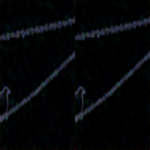
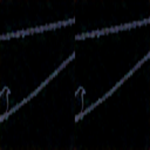
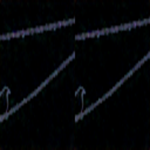
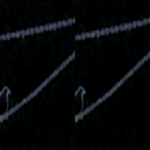
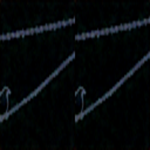
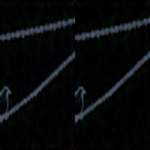
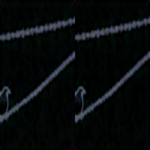
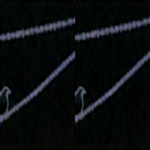
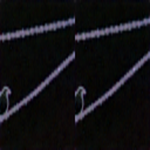


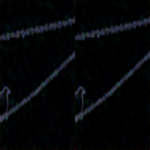
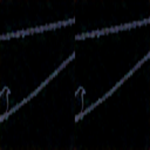
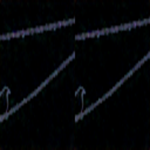
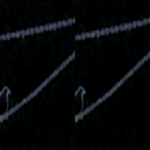
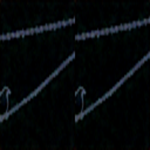
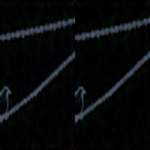
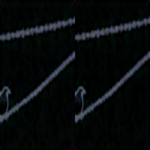
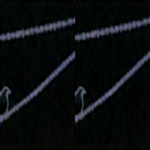
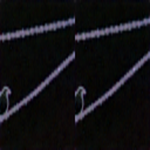

TypeError: 'Image' object does not support indexing

In [31]:
ipyplot.plot_images(image_array[90:99], max_images=100, img_width=150)


In [ ]:
from ipywidgets import interact


In [ ]:
def interactive_images(samples):
    def view_image(samples):
        image_show_pil(batch=samples)
    interact(view_image, samples=samples)

In [ ]:
interactive_images(samples)